In [1]:
from __future__ import annotations

import importlib
import pathlib

import plotly.express as px
import plotly.figure_factory as ff
import polars
import theme
from plotly.subplots import make_subplots

importlib.reload(theme)

<module 'theme' from '/home/jgpaul/workspace/sc24-proxystore-analysis/notebooks/theme.py'>

In [2]:
def load_data(filepath) -> polars.DataFrame:
    return polars.read_csv(filepath)

In [3]:
STAGES = {
    'processing_chrom_parts': 'Stage 1',
    'individuals': 'Stage 1',
    'processing_2': 'Stage 2',
    'merge': 'Stage 2',
    'sifting': 'Stage 3',
    'mutation_overlap': 'Stage 4',
    'frequency': 'Stage 5',
}

RUNS = {
    'gc-trial': 'Baseline',
    'proxy-bench-trial': 'ProxyFutures',
    'process-pool': 'Baseline (ProcessPool)',
    'process-pool-proxystore': 'ProxyFutures (ProcessPool)',
    'globus-compute': 'Baseline',
    'globus-compute-proxystore': 'ProxyFutures',
}


def merge_stages(data: polars.DataFrame) -> polars.DataFrame:
    out = []
    for run in RUNS:
        run_data = data.filter(polars.col('name') == run)
        if len(run_data) == 0:
            continue
        run_start = run_data['start'].min()
        for stage in STAGES:
            stage_data = run_data.filter(polars.col('task') == stage)
            if len(stage_data) == 0:
                continue
            for row in stage_data.iter_rows(named=True):
                start = row['start'] - run_start
                end = row['end'] - run_start
                out.append(
                    {
                        'run': RUNS[run],
                        'Start': start,
                        'Finish': end,
                        'Task': STAGES[stage],
                    },
                )

    return polars.DataFrame(out)

In [22]:
def make_gantt(data, layout=None):
    runs = set(data.select(polars.col('run')).to_series().to_list())
    fig = make_subplots(
        cols=1,
        rows=len(runs),
        vertical_spacing=0.05,
        shared_xaxes=True,
    )

    max_x_range = 0
    colors = [0, 4, 1, 2, 3]
    for row, run in enumerate(runs):
        run_data = data.filter(polars.col('run') == run)
        max_x_range = max(max_x_range, run_data['Finish'].max())
        timeline_fig = ff.create_gantt(
            run_data.to_dicts(),
            index_col='Task',
            show_colorbar=False,
            group_tasks=True,
            bar_width=0.475,
            colors=[px.colors.qualitative.Bold[i] for i in colors],
        )
        for stage in range(5):
            x = run_data.filter(polars.col('Task') == f'Stage {stage+1}')[
                'Start'
            ].min()
            fig.add_annotation(
                x=x + (20 if stage != 3 else 30),
                y=5 - (stage + 1),
                align='left',
                text=stage + 1,
                font=dict(size=10, color='white'),
                showarrow=False,
                row=row + 1,
                col=1,
            )
        # Crazy hacks to add traces in right order for legend
        traces = list(timeline_fig.data)
        for stage in [f'Stage {i}' for i in range(5)]:
            for trace in traces:
                if trace.name == stage:
                    fig.add_trace(trace, row=row + 1, col=1)
                    traces.remove(trace)
                    break
        for trace in traces:
            fig.add_trace(trace, row=row + 1, col=1)
        fig.update_yaxes(
            title_text=run,
            showticklabels=False,
            ticks='',
            row=row + 1,
            col=1,
            # autorange='reversed',
        )
        if row + 1 == len(runs):
            fig.update_xaxes(
                title_text='Runtime (s)',
                range=[0, max_x_range + 0.1],
                row=row + 1,
                col=1,
            )

    fig.update_traces(showlegend=True)
    names = set()
    fig.for_each_trace(
        lambda trace: trace.update(showlegend=False)
        if trace.name == '' or trace.name in names
        else names.add(trace.name),
    )

    layout = {} if layout is None else layout
    fig.update_layout(
        legend=dict(
            title=None,
            yanchor='top',
            y=0.85,
            xanchor='left',
            x=1.01,
            tracegroupgap=1,
        ),
        template='proxystore',
        **layout,
    )

    return fig

In [23]:
def get_deltas(data: polars.DataFrame) -> polars.DataFrame:
    processed = data.group_by('run', 'Task').agg(
        polars.col('Start').min(),
        polars.col('Finish').max(),
    )
    processed = processed.select(
        polars.col('run').alias('Run'),
        polars.col('Task').alias('Stage'),
        (polars.col('Finish') - polars.col('Start')).alias('Runtime'),
    )
    for run in set(data.select(polars.col('run')).to_series().to_list()):
        run_data = data.filter(polars.col('run') == run)
        runtime = run_data['Finish'].max() - run_data['Start'].min()
        print(f'{run} runtime: {runtime:.2f} s')
    processed = processed.pivot(
        index='Stage',
        columns='Run',
        values=None,
    ).sort(polars.col('Stage'))
    processed = processed.with_columns(
        (polars.col('Baseline') - polars.col('ProxyFutures')).alias(
            'Delta (s)',
        ),
        (
            100
            * (polars.col('Baseline') - polars.col('ProxyFutures'))
            / polars.col('Baseline')
        ).alias('Delta (%)'),
    )
    return processed

## Chameleon (1%)

Baseline runtime: 499.56 s
ProxyFutures runtime: 377.31 s
shape: (5, 5)
┌─────────┬────────────┬──────────────┬────────────┬───────────┐
│ Stage   ┆ Baseline   ┆ ProxyFutures ┆ Delta (s)  ┆ Delta (%) │
│ ---     ┆ ---        ┆ ---          ┆ ---        ┆ ---       │
│ str     ┆ f64        ┆ f64          ┆ f64        ┆ f64       │
╞═════════╪════════════╪══════════════╪════════════╪═══════════╡
│ Stage 1 ┆ 210.962937 ┆ 110.760734   ┆ 100.202203 ┆ 47.497539 │
│ Stage 2 ┆ 214.722628 ┆ 113.822504   ┆ 100.900125 ┆ 46.990914 │
│ Stage 3 ┆ 201.800962 ┆ 105.225084   ┆ 96.575877  ┆ 47.856996 │
│ Stage 4 ┆ 235.571252 ┆ 224.29193    ┆ 11.279323  ┆ 4.788073  │
│ Stage 5 ┆ 259.630495 ┆ 249.503309   ┆ 10.127186  ┆ 3.900615  │
└─────────┴────────────┴──────────────┴────────────┴───────────┘


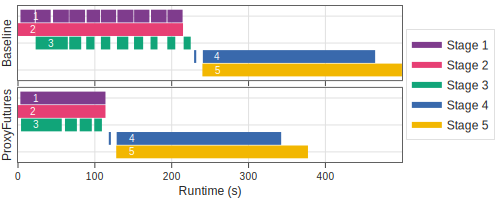

In [24]:
raw_data = load_data('../data/chameleon/3-1000genomes-1percent.csv')
data = merge_stages(raw_data)
print(get_deltas(data))

layout = dict(width=500, height=200, margin=dict(l=5, r=5, t=5, b=5))
fig = make_gantt(data, layout=layout)
fig.show(renderer='svg')

## Chameleon (10%)

Baseline runtime: 1150.71 s
ProxyFutures runtime: 731.12 s
shape: (5, 5)
┌─────────┬──────────────┬────────────┬────────────┬───────────┐
│ Stage   ┆ ProxyFutures ┆ Baseline   ┆ Delta (s)  ┆ Delta (%) │
│ ---     ┆ ---          ┆ ---        ┆ ---        ┆ ---       │
│ str     ┆ f64          ┆ f64        ┆ f64        ┆ f64       │
╞═════════╪══════════════╪════════════╪════════════╪═══════════╡
│ Stage 1 ┆ 459.679058   ┆ 851.86394  ┆ 392.184882 ┆ 46.038442 │
│ Stage 2 ┆ 462.014288   ┆ 856.399625 ┆ 394.385337 ┆ 46.051554 │
│ Stage 3 ┆ 403.30703    ┆ 782.909514 ┆ 379.602484 ┆ 48.486125 │
│ Stage 4 ┆ 230.503881   ┆ 241.951384 ┆ 11.447503  ┆ 4.731324  │
│ Stage 5 ┆ 255.283746   ┆ 267.460865 ┆ 12.177119  ┆ 4.55286   │
└─────────┴──────────────┴────────────┴────────────┴───────────┘


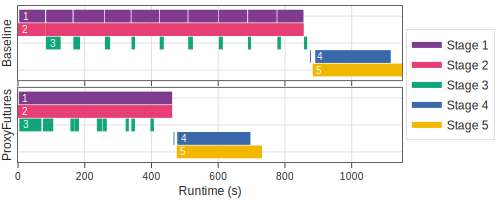

In [25]:
raw_data = load_data('../data/chameleon/3-1000genomes-5percent.csv')
data = merge_stages(raw_data)
print(get_deltas(data))

layout = dict(width=500, height=200, margin=dict(l=5, r=5, t=5, b=5))
fig = make_gantt(data, layout=layout)
fig.show(renderer='svg')

figure_dir = pathlib.Path('../figures/chameleon/')
figure_dir.mkdir(exist_ok=True)
fig.write_image(figure_dir / '3-1000-genomes.pdf')